# 2.0 DATA UNDERSTANDING STAGE

### Install required libraries 

# NB change cell from Markdown to Python
!pip install numpy
!pip install pandas
!pip install requests
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install imblearn
!pip install boruta


### Import Required libraries

In [1]:
import numpy as np
import pandas as pd
import requests
import zipfile
from io import BytesIO
import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from scipy.stats import chi2_contingency
from sklearn.linear_model import Ridge
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from boruta import BorutaPy




### Create URL of the zip file

In [2]:
secom_zip_url = "https://archive.ics.uci.edu/static/public/179/secom.zip"

### download the zipfile using request library

In [3]:
secom_zip_file = requests.get(secom_zip_url)

#### Identify list of the files on the zipfile

In [4]:
secom_files =  zipfile.ZipFile(BytesIO(secom_zip_file.content), 'r')

secom_files_names =  (zipfile.ZipFile(BytesIO(secom_zip_file.content))).namelist()
print(secom_files_names)

['secom.data', 'secom.names', 'secom_labels.data']


### create paths for features and label data

In [5]:
f_file = secom_files.open('secom.data')
l_file = secom_files.open('secom_labels.data')

In [6]:
#Create  column names and pandas dataframes for labels data

l_column_names=['classifications', 'date_time'] # create column labels

labels_df = pd.read_csv(l_file, sep=r'\s+', header=None, names= l_column_names)

print(f"Dimensions of Labels data: ", labels_df.shape)

print(labels_df.head())


Dimensions of Labels data:  (1567, 2)
   classifications            date_time
0               -1  19/07/2008 11:55:00
1               -1  19/07/2008 12:32:00
2                1  19/07/2008 13:17:00
3               -1  19/07/2008 14:43:00
4               -1  19/07/2008 15:22:00


#### convert time stamps column to datetime format and Check if the timestamps column is ordinal (from latest to ealatest  time)


In [7]:
labels_df['date_time'] = pd.to_datetime(labels_df['date_time'], format='%d/%m/%Y %H:%M:%S')

is_ascending = labels_df['date_time'].is_monotonic_increasing

if is_ascending:
    print("The timestamps column is in ascending order.")
else:
    print("The timestamps column is not in ascending order.")

The timestamps column is in ascending order.


#### Create column names pandas dataframes features data

In [8]:
f_column_names = [f"feature_{i}" for i in range(1, 592)]

secom_features_df = pd.read_csv(f_file, sep=r'\s+', header=None, names= f_column_names)
print(f"Dimensions of Features' data: ", secom_features_df.shape)

print(secom_features_df.head())

Dimensions of Features' data:  (1567, 591)
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0    3030.93    2564.00  2187.7333  1411.1265     1.3602      100.0   
1    3095.78    2465.14  2230.4222  1463.6606     0.8294      100.0   
2    2932.61    2559.94  2186.4111  1698.0172     1.5102      100.0   
3    2988.72    2479.90  2199.0333   909.7926     1.3204      100.0   
4    3032.24    2502.87  2233.3667  1326.5200     1.5334      100.0   

   feature_7  feature_8  feature_9  feature_10  ...  feature_582  feature_583  \
0    97.6133     0.1242     1.5005      0.0162  ...          NaN       0.5005   
1   102.3433     0.1247     1.4966     -0.0005  ...     208.2045       0.5019   
2    95.4878     0.1241     1.4436      0.0041  ...      82.8602       0.4958   
3   104.2367     0.1217     1.4882     -0.0124  ...      73.8432       0.4990   
4   100.3967     0.1235     1.5031     -0.0031  ...          NaN       0.4800   

   feature_584  feature_585  feature_586  f

### Draw Histogram of Volatilities

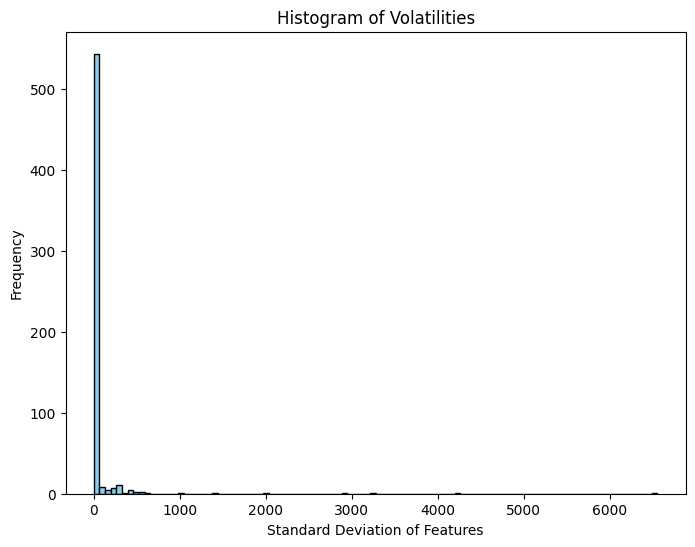

In [9]:
import matplotlib.pyplot as plt
# Calculate volatilities (standard deviations) for each column
volatilities = secom_features_df.std()

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(volatilities, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Standard Deviation of Features')
plt.ylabel('Frequency')
plt.title('Histogram of Volatilities')
plt.grid(False)
plt.show()

### Draw a frequency distribution table and a pie chart of the classification variable

Frequency Distribution Table:
   Class  Frequency  Percentage
0     -1       1463   93.363114
1      1        104    6.636886


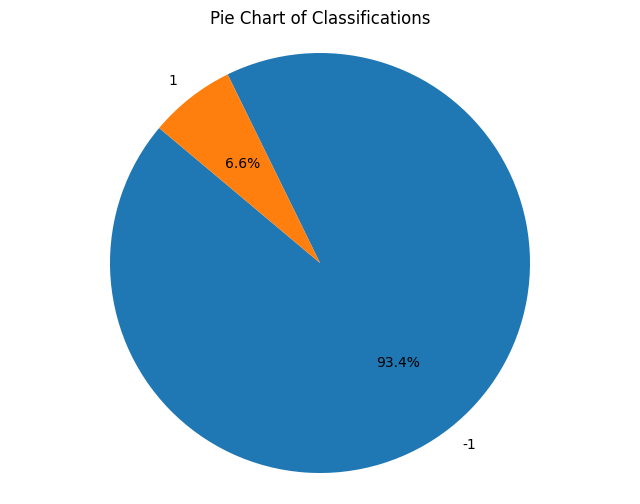

In [10]:
# Calculate frequency distribution
frequency_table = labels_df['classifications'].value_counts().reset_index()
frequency_table.columns = ['Class', 'Frequency']

# Calculate percentage
total_count = frequency_table['Frequency'].sum()
frequency_table['Percentage'] = (frequency_table['Frequency'] / total_count) * 100

# Display frequency distribution table
print("Frequency Distribution Table:")
print(frequency_table)

# Plot pie chart
plt.figure(figsize=(8, 6))
plt.pie(frequency_table['Frequency'], labels=frequency_table['Class'], autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of Classifications')
plt.axis('equal')
plt.show()


### Correlation heatmap

           feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
feature_1   1.000000  -0.145071   0.004775  -0.007655  -0.011047        NaN   
feature_2  -0.145071   1.000000   0.005802  -0.007603  -0.001641        NaN   
feature_3   0.004775   0.005802   1.000000   0.298935   0.095891        NaN   
feature_4  -0.007655  -0.007603   0.298935   1.000000  -0.058483        NaN   
feature_5  -0.011047  -0.001641   0.095891  -0.058483   1.000000        NaN   

           feature_7  feature_8  feature_9  feature_10  ...  feature_582  \
feature_1   0.002281   0.031510  -0.052731    0.009052  ...    -0.028380   
feature_2  -0.025702  -0.012084   0.031321    0.024015  ...     0.083463   
feature_3  -0.136225  -0.273970   0.023609    0.016291  ...    -0.010759   
feature_4  -0.685835   0.138290  -0.103656    0.068998  ...    -0.096619   
feature_5  -0.074368  -0.916410  -0.026035    0.054619  ...     0.088327   

           feature_583  feature_584  feature_585  feature_586  featu

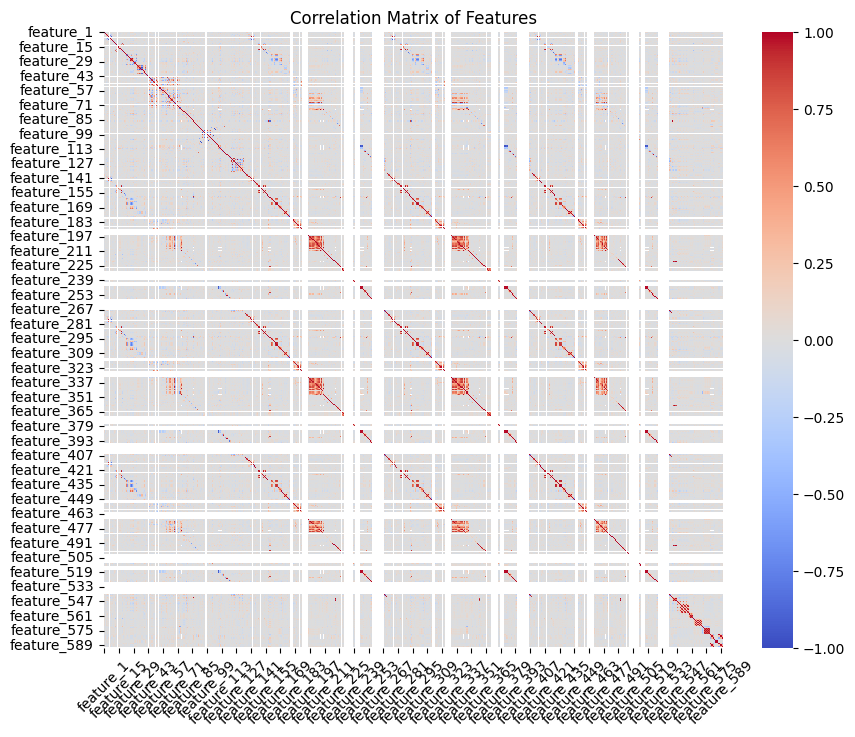

In [11]:
import seaborn as sns
# Compute the correlation matrix
correlation_matrix = secom_features_df.corr()
print(correlation_matrix.head())
# Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)   # Rotate y-axis labels for better readability
plt.show()

###  Check the Count and Percentages of Missing values in the dataframe

Number of columns WITHOUT Missing Values:
52
Number of columns WITH Missing Values:
539
Frequency Table of Percentage of Missing Values in Each Column:
     Bin  Frequency
0  <=55%        514
1   >55%         25


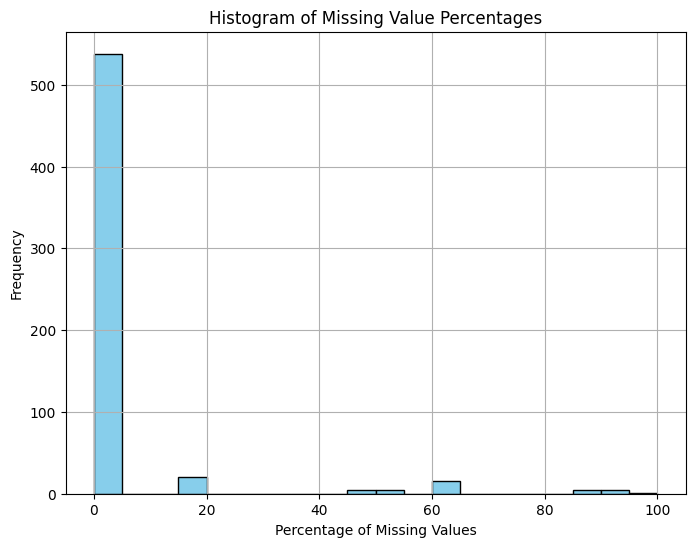

In [12]:

# Calculate percentage of missing values in each column
missing_percentages2 = (secom_features_df.isnull().sum() / len(secom_features_df)) * 100

# Create bins
bins = [0, 55, 100]

# Use pd.cut to categorize percentages into bins
bin_labels = ['<=55%', '>55%']
categories = pd.cut(missing_percentages2, bins, labels=bin_labels)

# Create a DataFrame to store the frequency table
frequency_table2 = categories.value_counts().reset_index()
frequency_table2.columns = ['Bin', 'Frequency']

# Determine the number of columns with and without missing values
print("Number of columns WITHOUT Missing Values:")
print((secom_features_df.isnull().sum() == 0).sum())

print("Number of columns WITH Missing Values:")
print((secom_features_df.isnull().sum()>0).sum())


print("Frequency Table of Percentage of Missing Values in Each Column:")
print(frequency_table2)

# Plot a histogram of the missing value percentages
plt.figure(figsize=(8, 6))
plt.hist(missing_percentages2, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Frequency')
plt.title('Histogram of Missing Value Percentages')
plt.grid(True)
plt.show()




In [13]:
# duplicate identification

# Find columns with 100% duplicate values
columns_with_100_percent_duplicates = secom_features_df.columns[secom_features_df.nunique() == 1]

print("Columns with 100% duplicate values:")
print(len(columns_with_100_percent_duplicates))

print("Pecentage of Columns with 100% duplicate values:")

print(len(columns_with_100_percent_duplicates)/len(secom_features_df.columns)*100, "%")


Columns with 100% duplicate values:
116
Pecentage of Columns with 100% duplicate values:
19.627749576988155 %


# 3.0 DATA PREPARATION

### Merge the Features and Labels data frames

In [14]:
secom_merged_df = pd.merge(labels_df, secom_features_df, left_index=True, right_index=True)

print(f"Dimensions of merged data: ", secom_merged_df.shape)

print(secom_merged_df.head())

Dimensions of merged data:  (1567, 593)
   classifications           date_time  feature_1  feature_2  feature_3  \
0               -1 2008-07-19 11:55:00    3030.93    2564.00  2187.7333   
1               -1 2008-07-19 12:32:00    3095.78    2465.14  2230.4222   
2                1 2008-07-19 13:17:00    2932.61    2559.94  2186.4111   
3               -1 2008-07-19 14:43:00    2988.72    2479.90  2199.0333   
4               -1 2008-07-19 15:22:00    3032.24    2502.87  2233.3667   

   feature_4  feature_5  feature_6  feature_7  feature_8  ...  feature_582  \
0  1411.1265     1.3602      100.0    97.6133     0.1242  ...          NaN   
1  1463.6606     0.8294      100.0   102.3433     0.1247  ...     208.2045   
2  1698.0172     1.5102      100.0    95.4878     0.1241  ...      82.8602   
3   909.7926     1.3204      100.0   104.2367     0.1217  ...      73.8432   
4  1326.5200     1.5334      100.0   100.3967     0.1235  ...          NaN   

   feature_583  feature_584  feature_585

### Split data into Training and Test data

In [15]:
# Seperate features series and target variable series
X = secom_merged_df.drop(["classifications", "date_time"], axis=1).values
y = secom_merged_df["classifications"].values

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

### Descriptives of trian and test data for both features and target variable

##### check the shape of train and test datasets

In [16]:
print("Shape of features training data: ")
print(np.shape(X_train))
print("Shape of target training data: ")
print(np.shape(y_train))
print("Shape of features test data: ")
print(np.shape(X_test))
print("Shape of taget test data: ")
print(np.shape(y_test))

Shape of features training data: 
(1175, 591)
Shape of target training data: 
(1175,)
Shape of features test data: 
(392, 591)
Shape of taget test data: 
(392,)


#### Check the composition of the target variable in the Training and test data

In [17]:
#Create a function to create frequency table

def draw_frequency(data):
    # Calculate frequency distribution
    unique_values, counts = np.unique(data, return_counts=True)

    # Calculate total count
    total_count = len(data)

    # Calculate percentage distribution
    percentage_counts = counts / total_count * 100

    # Merge frequency and percentage distributions into a single NumPy array
    distribution = np.stack((unique_values, counts, percentage_counts), axis=-1)
    
    # Convert them to pandas DataFrame
    distribution_df = pd.DataFrame(distribution, columns=['Class', 'Frequency', 'Percentage'])

    return distribution_df

# Draw the distribution of target variable in training and test data set
freuency_y_trn = draw_frequency(y_train)
frequency_y_tst= draw_frequency(y_test)
# Print the result
print("Distribution of target values in train data:")
print(freuency_y_trn)

print("Distribution of target values in test data:")
print(frequency_y_tst)



Distribution of target values in train data:
   Class  Frequency  Percentage
0   -1.0     1097.0   93.361702
1    1.0       78.0    6.638298
Distribution of target values in test data:
   Class  Frequency  Percentage
0   -1.0      366.0   93.367347
1    1.0       26.0    6.632653


### Variance of columns

Number of columns with zero variance: 116
Proportion of Columns with zero variance:
19.627749576988155 %


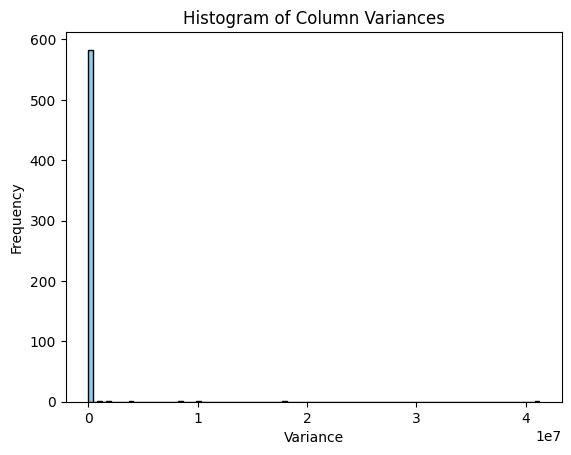

In [18]:
# Convert X_train data to Pandas df
X_train_df = pd.DataFrame(X_train, columns=f_column_names)

# Calculate the variance of each column
column_variances = X_train_df.var()

# Subset the columns with zero variance
zero_variance_columns = column_variances[column_variances == 0].index.tolist()

# Print the columns with zero variance
print("Number of columns with zero variance:", len(zero_variance_columns))

print("Proportion of Columns with zero variance:")

print(len(zero_variance_columns)/len(X_train_df.columns)*100, "%")

#plot histogam of variance

plt.hist(column_variances, bins=100, color='skyblue', edgecolor='black')
plt.title('Histogram of Column Variances')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.show()

In [19]:
# Convert X_test data to Pandas df

X_test_df = pd.DataFrame(X_test, columns=f_column_names)

###  Check the Count and Percentages of Missing values in each feature

The total number of features WITHOUT Missing Values:
128
The total number of features WITH Missing Values:
463
The total number of features with NAs WITHIN the threshold of 80% NAs:
454
The total number of features with NAs ABOVE the threshold of 80% NAs:
9


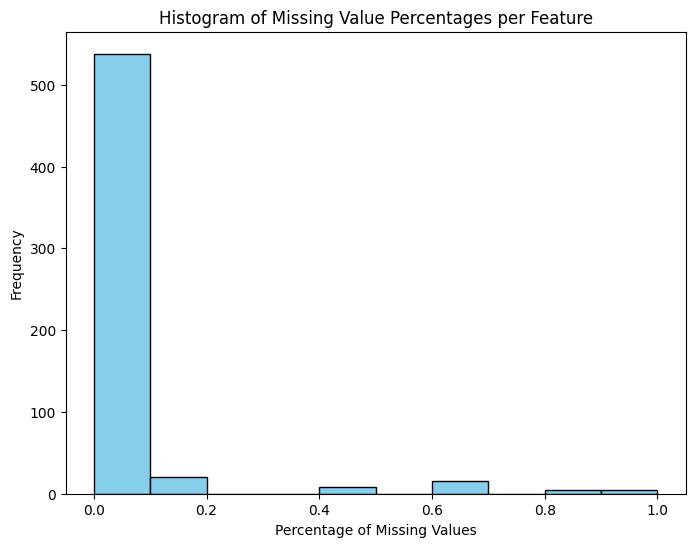

In [20]:
# Calculate percentage of missing values in each feature 
missing_df= X_train_df.isnull().mean()

# Determine the number of features with and without missing values
print("The total number of features WITHOUT Missing Values:")
print((missing_df == 0).sum())

print("The total number of features WITH Missing Values:")
print((missing_df > 0).sum())

# Determine the number of features WITHIN the threshold of 80% NAs

print("The total number of features with NAs WITHIN the threshold of 80% NAs:")
print(((missing_df > 0) & (missing_df <=0.80)).sum())

# Determine the number of features ABOVE the threshold of 80% NAs

print("The total number of features with NAs ABOVE the threshold of 80% NAs:")
print((missing_df > 0.80).sum())


# Plot a histogram of the missing value percentages
plt.figure(figsize=(8, 6))
plt.hist(missing_df, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Frequency')
plt.title('Histogram of Missing Value Percentages per Feature')
plt.grid(False)

### Correlation heatmap of X-train data

           feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
feature_1   1.000000  -0.126566   0.000575   0.013373  -0.006222        NaN   
feature_2  -0.126566   1.000000  -0.002103   0.005802  -0.004174        NaN   
feature_3   0.000575  -0.002103   1.000000   0.318834   0.025843        NaN   
feature_4   0.013373   0.005802   0.318834   1.000000  -0.019419        NaN   
feature_5  -0.006222  -0.004174   0.025843  -0.019419   1.000000        NaN   

           feature_7  feature_8  feature_9  feature_10  ...  feature_582  \
feature_1  -0.024898   0.044185  -0.020168    0.018319  ...    -0.020948   
feature_2  -0.031952   0.004616   0.036839    0.014511  ...     0.074886   
feature_3  -0.146916  -0.422301   0.030255   -0.006386  ...    -0.014590   
feature_4  -0.686292   0.179327  -0.095718    0.068795  ...    -0.074088   
feature_5  -0.102886   0.052054   0.000949    0.005682  ...     0.000050   

           feature_583  feature_584  feature_585  feature_586  featu

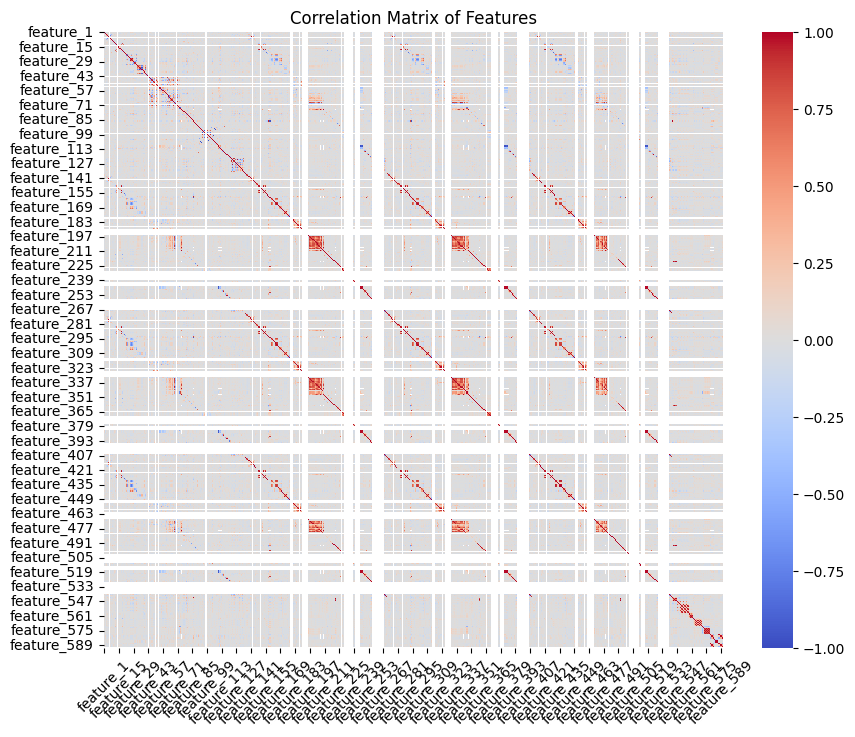

In [21]:
import seaborn as sns
# Compute the correlation matrix
correlation_matrix_Xtrn = X_train_df.corr()
print(correlation_matrix_Xtrn.head())
# Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_Xtrn, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)   # Rotate y-axis labels for better readability
plt.show()

### Create a function to determine highly correlated pair of features

In [22]:
# Create a function to determine highly correlated pair of features above threshold of 0.95
# Determine which features to drop according to Munirathinam & Ramadoss (2016)
# Among each pair, Drop the feature with the highest average correlation with all features
def find_highly_correlated_pairs(df, correlation_threshold=0.95):
    # Step 1: Calculate the correlation matrix
    correlation_matrix = df.corr()
    
    # Step 2: Find pairs of predictors with correlation >= threshold
    high_correlation_pairs = []
    columns = correlation_matrix.columns
    
    # Loop over the upper triangle of the correlation matrix (excluding diagonal)
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            if abs(correlation_matrix.iloc[i, j]) >= correlation_threshold:
                high_correlation_pairs.append((columns[i], columns[j]))

    # Step 3: Create a DataFrame to store the pairs and their correlations
    high_corr_df = pd.DataFrame(high_correlation_pairs, columns=['Predictor_A', 'Predictor_B'])
    high_corr_df['Correlation'] = [
        correlation_matrix.loc[pair[0], pair[1]] for pair in high_correlation_pairs
    ]
    
    # Step 4: Calculate average correlation with other predictors for each element of each pair
    avg_correlation = {}
    
    for col in columns:
        # Calculate the average correlation of a predictor with all others excluding itself
        avg_correlation[col] = correlation_matrix[col].drop(col).abs().mean()
    
    # Add the average correlation to the DataFrame
    high_corr_df['Avg_Corr_A'] = high_corr_df['Predictor_A'].apply(lambda x: avg_correlation[x])
    high_corr_df['Avg_Corr_B'] = high_corr_df['Predictor_B'].apply(lambda x: avg_correlation[x])

    # Step 5: Determine which element has the higher average correlation with other predictors
    # You need to compare the values for each row and assign the predictor with the higher correlation
    high_corr_df['highest_to_delete'] = high_corr_df.apply(
        lambda row: row['Predictor_A'] if row['Avg_Corr_A'] > row['Avg_Corr_B'] else row['Predictor_B'], axis=1
    )

    return high_corr_df

### Determine the list of highly correlated pair of features and
### Create the the list of highly correlated of features to DROP

In [23]:
# Create a dataframe to determine the highly correlated pair of features
correlation_result = find_highly_correlated_pairs(X_train_df, correlation_threshold=0.95)
print(correlation_result.head())
print(correlation_result.tail())

# Determine the List of unique Features to Drop
features_to_drop =correlation_result['highest_to_delete']
features_to_drop_unq =correlation_result['highest_to_delete'].unique()
# Print the first 5 features and the number of features to drop
print(features_to_drop_unq[1:6])

print("Number of highly correlated Features to drop:", len(features_to_drop))

print("Unique number of highly correlated Features to drop:", len(features_to_drop_unq))



  Predictor_A  Predictor_B  Correlation  Avg_Corr_A  Avg_Corr_B  \
0   feature_5  feature_141     0.999963    0.029937    0.029817   
1   feature_5  feature_276     0.999964    0.029937    0.029719   
2  feature_17  feature_149     0.978889    0.044948    0.043396   
3  feature_17  feature_153     0.984235    0.044948    0.044442   
4  feature_17  feature_284     0.979643    0.044948    0.043636   

  highest_to_delete  
0         feature_5  
1         feature_5  
2        feature_17  
3        feature_17  
4        feature_17  
     Predictor_A  Predictor_B  Correlation  Avg_Corr_A  Avg_Corr_B  \
335  feature_582  feature_590     1.000000    0.053581    0.042554   
336  feature_584  feature_585     0.996055    0.029074    0.029277   
337  feature_584  feature_586     0.999916    0.029074    0.029103   
338  feature_585  feature_586     0.996450    0.029277    0.029103   
339  feature_588  feature_589     0.971941    0.037520    0.036102   

    highest_to_delete  
335       feature_58

### DATA PREPARATION

### Removing low variance columns

In [24]:
# Function to get low-variance columns
def low_variance_columns(df, variance_threshold=0.95):

    # Compute variance for each column
    column_variance = df.var()
    
    # Select columns with variance below the threshold
    low_variance_cols = column_variance[column_variance < variance_threshold].index
    
    # Return a DataFrame containing only the low-variance columns
    return df[low_variance_cols]

zero_var_cols = low_variance_columns(X_train_df)
# Create list of columns to drop
col_to_drop1=zero_var_cols.columns.tolist()
print(zero_var_cols.shape)
print(col_to_drop1)


(1175, 345)
['feature_6', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_14', 'feature_18', 'feature_20', 'feature_21', 'feature_26', 'feature_27', 'feature_30', 'feature_31', 'feature_32', 'feature_38', 'feature_39', 'feature_43', 'feature_45', 'feature_48', 'feature_50', 'feature_53', 'feature_54', 'feature_55', 'feature_57', 'feature_58', 'feature_59', 'feature_62', 'feature_70', 'feature_75', 'feature_76', 'feature_77', 'feature_78', 'feature_79', 'feature_80', 'feature_81', 'feature_82', 'feature_83', 'feature_84', 'feature_85', 'feature_86', 'feature_87', 'feature_88', 'feature_90', 'feature_92', 'feature_93', 'feature_94', 'feature_95', 'feature_96', 'feature_97', 'feature_98', 'feature_99', 'feature_100', 'feature_101', 'feature_102', 'feature_103', 'feature_104', 'feature_105', 'feature_106', 'feature_107', 'feature_108', 'feature_109', 'feature_110', 'feature_113', 'feature_114', 'feature_115', 'feature_117', 'feature_119', 'feature_120', 'featur

### Create new dataframe without low variance columns

In [25]:
# Function to get low-variance columns
def drop_low_var_columns(df, variance_threshold=0.0000000001):

    # Compute variance for each column
    column_variance = df.var()
    
    # Select columns with variance below the threshold
    low_variance_cols = column_variance[column_variance < variance_threshold].index
    
    # Return a DataFrame without low-variance columns
  
    return df.drop(columns=low_variance_cols)

# Create a new dataframe without low variance columns
X_train_df1 = drop_low_var_columns(X_train_df)

# Create a list of columns dropped
columns_dropped1 = list(set(X_train_df.columns) - set(X_train_df1.columns))

# confirm the changes in number of columns

print("Original number of columns: ", X_train_df.shape[1])
print("Number of columns dropped: ", len(columns_dropped1))
print("New number of columns: ", X_train_df1.shape[1])



Original number of columns:  591
Number of columns dropped:  116
New number of columns:  475


### Drop Null Values columns below percentage threshold

In [26]:
# Function to drop missing values below a given treshhold

def drop_na_columns(df, threshold): # threshold in absolute percentage e.g. 90

    # Create missing values df
    na_percent = round(df.isnull().mean() * 100)

       # Create a list of columns with missing values above the threshold
    cols_to_drop = na_percent[na_percent > threshold].index.tolist()
    
    # Print the columns to be dropped for debugging
    print(f"Columns to be dropped (greater than {threshold}% missing values): {cols_to_drop}")
    
    # Print number of columns of original datafame
    print("Original number of columns: ", len(df.columns))
    
    # Print number of columns dropped
    print("Number of columns dropped: ", len(cols_to_drop))
    
    
    # Return a new DataFrame with the specified columns dropped
    df_cleaned = df.drop(columns=cols_to_drop)
    
    return df_cleaned


    

In [27]:
# Drop NAs columns
X_train_df2 = drop_na_columns(X_train_df1, 70)



Columns to be dropped (greater than 70% missing values): ['feature_86', 'feature_158', 'feature_159', 'feature_221', 'feature_293', 'feature_294', 'feature_359', 'feature_493', 'feature_591']
Original number of columns:  475
Number of columns dropped:  9


In [28]:
len(X_train_df2.columns)

466

In [29]:
columns_dropped2= ['feature_86', 'feature_158', 'feature_159', 'feature_221', 'feature_293', 'feature_294', 'feature_359', 'feature_493', 'feature_591']

In [30]:
#Drop columns iwth zero variance for test data
X_test_df1= X_test_df.drop(columns=columns_dropped1)

# Drop columns with  with 70%+ NAs
X_test_df2= X_test_df1.drop(columns=columns_dropped2)

### Outliers Identification based on 3s rule

In [31]:
# Define function
def identify_outliers(df):
   
    # Calculate mean and standard deviation
    mean = df.mean()
    std_dev = df.std()
    
    # Define boundaries for outliers
    upper_bound = mean + 3 * std_dev
    lower_bound = mean - 3 * std_dev
    
    # Create a boolean mask for outliers
    outliers_mask = (df > upper_bound) | (df < lower_bound)
    
    return outliers_mask

outliers_df= identify_outliers(X_train_df3)

print(outliers_df.sum().sum())
print(outliers_df.sum().sum()/X_train_df3.sum().sum())

### Create a function to fill Outliers with 3s boundaries

In [32]:
def identify_lower_upper(df):
   
    # Calculate mean and standard deviation
    mean = df.mean()
    std_dev = df.std()
    
    # Define boundaries for outliers
    upper_bound = mean + 3 * std_dev
    lower_bound = mean - 3 * std_dev
    
    
    return lower_bound, upper_bound

In [33]:
# outlierFill function
def fill_outliers(df):
   
    # Calculate mean and standard deviation
    mean = df.mean()
    std_dev = df.std()
    
    # Define boundaries for outliers
    upper_bound = mean + 3 * std_dev
    lower_bound = mean - 3 * std_dev
    
    # Create a boolean mask for outliers
    df_filled = df.clip(lower=lower_bound, upper=upper_bound, axis=1)
    
    return df_filled


### Fill Outliers with 3s boundaries 

In [34]:
X_train_filled = fill_outliers(X_train_df2)
print(X_train_filled)


      feature_1  feature_2  feature_3  feature_4  feature_5  feature_7  \
0       3057.03    2468.41  2184.8778   960.8486     1.0160   102.5333   
1       3012.09    2551.08  2216.7333  1748.0885     1.1127    97.5822   
2       3032.81    2534.74  2239.4223  1997.3782     1.5397    98.3356   
3       2987.72    2550.52  2180.7000  1159.3838     1.0177    98.9367   
4       3001.90    2465.51  2223.0444  1194.5986     1.2016   112.5811   
...         ...        ...        ...        ...        ...        ...   
1170    3185.69    2537.68  2173.2778  1116.2950     0.8525   103.8200   
1171    2988.92    2460.91  2178.0778   941.9524     0.8039   104.0167   
1172    2975.74    2517.35  2162.5556  1041.0369     1.4305   100.4111   
1173    2928.16    2523.21  2210.6111  1184.6481     1.2577   102.9356   
1174    2929.84    2504.50  2183.3111  1588.5090     1.6269   102.8467   

      feature_8  feature_9  feature_10  feature_11  ...  feature_581  \
0        0.1214     1.4549     -0.0125 

In [35]:
X_test_filled = fill_outliers(X_test_df2)
print(X_test_filled)

     feature_1  feature_2  feature_3  feature_4  feature_5  feature_7  \
0      3017.35    2580.25  2223.0444  1194.5986     1.2016   112.5811   
1      3070.43    2446.38  2255.5222  1763.0739     1.2226   101.5878   
2      3086.05    2417.34  2216.5000  1111.5436     0.8373    99.9867   
3      3097.14    2463.06  2155.3111   918.2161     1.2753   105.0478   
4      2960.54    2508.09  2164.3000  1031.4032     1.3626   102.1322   
..         ...        ...        ...        ...        ...        ...   
387    2831.18    2579.49  2200.1222  1478.2288     2.2079    97.7778   
388    2948.76    2644.32  2185.3334  1780.4149     1.7632    93.9844   
389    2977.43    2297.30  2218.0555  1517.4371     0.8579   105.8133   
390    3002.54    2549.85  2182.5555  1261.0898     1.2110   112.2922   
391    2927.71    2525.39  2199.6556  1140.3983     1.3369   103.0967   

     feature_8  feature_9  feature_10  feature_11  ...  feature_581  \
0       0.1229     1.4036     -0.0014      0.0015  .

In [36]:
# Confirm that outliers have been filled with class boundaries
print("Original dataframe WITH outliers:")
print(X_train_df2["feature_590"].head(4))
print("lower bound, upper bound: ", identify_lower_upper(X_train_df2["feature_590"]))
print("New dataframe WITHOUT outliers:")
print(X_train_filled["feature_590"].head(4))



Original dataframe WITH outliers:
0     62.1248
1     62.3602
2     35.5550
3    474.0812
Name: feature_590, dtype: float64
lower bound, upper bound:  (-182.016242088725, 378.8615799081458)
New dataframe WITHOUT outliers:
0     62.12480
1     62.36020
2     35.55500
3    378.86158
Name: feature_590, dtype: float64


## DATA INPUTATION

#### Create a function to input missing values

In [37]:
# Impute with KNN function
def fill_nas_knn (df):
    
    # Define the imputer
    imputer = KNNImputer(n_neighbors=3)  # You can adjust the number of neighbors
    
    # Apply the imputer to the DataFrame
    df_imputed = imputer.fit_transform(df)
    return df_imputed

In [38]:
# Fill in NAs with KNN
X_train_imputed_knn= fill_nas_knn(X_train_filled)

In [39]:
X_test_imputed_knn= fill_nas_knn(X_test_filled)

# Feature selection with 
###to be worked on

#### Input NAs tih stochastic regression



from sklearn.experimental import enable_iterative_imputer  # Enable experimental feature
from sklearn.impute import IterativeImputer
# Create a function to inpute NAs with BayesianRidge as the estimator
def impute_na (data):
    # Create an IterativeImputer with BayesianRidge as the estimator
    imputer = IterativeImputer(max_iter=20, random_state=42)

    # Fit the imputer to the DataFrame and transform it to fill in missing values
    data_imputed = imputer.fit_transform(data)
    
    # Create a new DataFrame with the imputed values
    return data_imputed

# impute NAs and create imputed data

X_train_imputed_reg = impute_na(X_train_filled)


# check if there are still NAs
print ("Number of NaNs: ",np.sum(np.isnan(X_train_imputed_reg[1:6, :])))

#### Create a new dataframe with inputted NAs

### Scaling and Resampling of Features

Scaling the dataset with function

In [40]:
# Create a function for resampling the dataframe

def scale_dataset(data):

  scaler = MinMaxScaler(feature_range=(-1, 1))
  data_scaled = scaler.fit_transform(data)


  return data_scaled

In [41]:
# Scale the train dataset

X_train_scaled1 = scale_dataset(X_train_imputed_knn)
#X_train_scaled2 = scale_dataset(X_train_imputed_reg)
print (X_train_scaled1[1:2, :])
#print (X_train_scaled2[1:2, :])

[[-6.11031749e-03  2.24999223e-01  1.87371929e-01  3.89152922e-02
  -9.93865307e-01 -1.91060896e-01  7.19038775e-01  3.11035980e-01
  -2.51169652e-01  4.58184480e-01 -1.29100902e-01 -9.75741561e-02
  -7.07949864e-01 -5.70430244e-01 -3.07622167e-01  5.60342149e-01
  -1.19829991e-01  4.66624422e-01  1.14548103e-01 -6.90580838e-01
   2.70658507e-01 -5.84536696e-01  1.56278715e-01 -1.11588224e-01
   5.47736533e-01 -7.64735108e-02  3.46551351e-01  3.44233127e-01
  -5.34745872e-02  8.85906531e-01 -6.20527426e-01 -6.03129278e-01
  -9.45525792e-01 -7.93995656e-01  9.45525700e-01 -3.58949956e-01
   4.33274041e-02 -8.77174826e-02  8.02843060e-01 -2.92565743e-01
  -5.18049236e-02  3.81656839e-01 -2.78940618e-01 -1.90427458e-01
  -3.97088866e-01 -9.65052816e-02 -2.55488021e-01 -2.72647559e-01
   3.39210495e-01  4.01468989e-01 -7.71062502e-02  2.73146231e-01
  -1.22182929e-01 -3.43560223e-02  5.69571723e-01  1.90569209e-01
   1.00340450e-01 -2.08553299e-01 -3.05660805e-01 -3.92433588e-01
  -2.82837

Resampling of Training dataset

In [42]:
from imblearn.over_sampling import RandomOverSampler

# Create a function for resampling the dataframe

def balance_dataset(X, y, oversample=True):

# Balance data set 
  if oversample:
    ros = RandomOverSampler()
    X_oversampled, y_oversampled = ros.fit_resample(X, y)

  return X_oversampled, y_oversampled

##### Scale and balance train dataset

In [43]:
# oversample scaled data
X_train_balanced1, y_train_balanced1 = balance_dataset(X_train_scaled1, y_train)
 
#X_train_balanced2, y_train_balanced2 = balance_dataset(X_train_scaled2, y_train)

In [44]:
# oversample unscaled data
X_train_balanced_uknn, y_train_balanced_uknn = balance_dataset(X_train_imputed_knn, y_train)
#X_train_balanced_ureg, y_train_balanced_ureg = balance_dataset(X_train_imputed_reg, y_train)


In [45]:
# Use SMOTE for oversampling the minority class in the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled1, y_train)

In [46]:
# Check the number of records before and after over sampling
print("RECORDS BEFORE RESAMPLING")
print("The Total number of records of negative classification: ", len(X_train))
print("The Total number of records of  classification variable: ", len(y_train))
print("The number of Positive classifications: ", len(y_train[y_train == 1]))
print("The number of negative classifications: ", len(y_train[y_train == -1]))

print("RECORDS AFTER RESAMPLING")
print("The Total number of records of negative classification: ", len(X_train_balanced1))
print("The Total number of records of  classification variable: ", len(y_train_balanced1))
print("The number of Positive classifications: ", len(y_train_balanced1[y_train_balanced1 == 1]))
print("The number of negative classifications: ", len(y_train_balanced1[y_train_balanced1 == -1]))


RECORDS BEFORE RESAMPLING
The Total number of records of negative classification:  1175
The Total number of records of  classification variable:  1175
The number of Positive classifications:  78
The number of negative classifications:  1097
RECORDS AFTER RESAMPLING
The Total number of records of negative classification:  2194
The Total number of records of  classification variable:  2194
The number of Positive classifications:  1097
The number of negative classifications:  1097


### Model Building, Evalutation and Selection

#### Models building

In [47]:

# Define KFold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

# Define the models to be used
models = {
    'KNN': KNeighborsClassifier(n_neighbors=3),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(), 'Logistic regression' : LogisticRegression(),
    'GaussianNB' : GaussianNB()  
}



#### Evaluate the models

In [48]:
# Evaluate each model with KFold cross-validation and collect the results
model_results = {}
for model_name, model in models.items():
    # Use cross_val_score to evaluate the pipeline with KFold
    scores = cross_val_score(model, X_train_scaled1, y_train, cv=kfold, scoring='accuracy')
    model_results[model_name] = scores.mean()  # Store the mean accuracy of the model

print("Cross-validation results (mean accuracy):")
for model_name, mean_score in model_results.items():
    print(f"{model_name}: {mean_score:.4f}")

c:\Users\Majeed Win10\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Majeed Win10\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Cross-validation results (mean accuracy):
KNN: 0.9234
Random Forest: 0.9336
Decision Tree: 0.8783
SVM: 0.9336
Logistic regression: 0.9055
GaussianNB: 0.2052


In [49]:
# Evaluate each model with KFold cross-validation and collect the results
model_results = {}
for model_name, model in models.items():
    # Use cross_val_score to evaluate the pipeline with KFold
    scores = cross_val_score(model, X_train_balanced1, y_train_balanced1, cv=kfold, scoring='accuracy')
    model_results[model_name] = scores.mean()  # Store the mean accuracy of the model

print("Cross-validation results (mean accuracy):")
for model_name, mean_score in model_results.items():
    print(f"{model_name}: {mean_score:.4f}")

c:\Users\Majeed Win10\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Majeed Win10\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Cross-validation results (mean accuracy):
KNN: 0.9407
Random Forest: 1.0000
Decision Tree: 0.9658
SVM: 0.9831
Logistic regression: 0.9335
GaussianNB: 0.5674


In [50]:
# Define a Random Forest model
rf = RandomForestClassifier()

# Define a parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
}
# Define a GridSearchCV instance
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the grid search to your data
grid_search.fit(X_train_balanced1, y_train_balanced1)

# Output the best parameters
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

c:\Users\Majeed Win10\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
243 fits failed out of a total of 486.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
116 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Majeed Win10\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Majeed Win10\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\Majeed Win10\AppData\Local\Programs\Python\Python312\Li

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score: 1.0


#### Imput and standardise Test Dataset

In [51]:
# Convert X_train data to Pandas df
X_test_df = pd.DataFrame(X_test, columns=f_column_names)
print(X_test_df.shape)

(392, 591)


In [52]:
# Drop low variance columns
X_test_low_var =X_test_df.drop(columns=columns_dropped1)
print(X_test_low_var.shape[1])

475


In [53]:
# Drop NAs columns
X_test_nadroped = X_test_low_var.drop(columns=columns_dropped2)
print(X_test_nadroped.shape[1])

466


In [54]:
# Replace outliers with 3s bounds
X_test_filled = fill_outliers(X_test_nadroped)

print(X_test_filled.shape)

(392, 466)


In [55]:
# Impute NAs
X_test_imputed1 = fill_nas_knn(X_test_filled)
print(X_test_imputed1[1:4,:])

[[3.0704300e+03 2.4463800e+03 2.2555222e+03 ... 8.7000000e-03
  3.2000000e-03 4.1061100e+01]
 [3.0860500e+03 2.4173400e+03 2.2165000e+03 ... 1.9000000e-02
  5.3000000e-03 1.0138760e+02]
 [3.0971400e+03 2.4630600e+03 2.1553111e+03 ... 1.0900000e-02
  3.6000000e-03 5.1547200e+01]]


In [56]:
# Scale the test dataset
X_test_scaled1= scale_dataset(X_test_imputed1)
print(X_test_scaled1[1:2,1:10])

[[-0.1928166   0.61022433  0.26422652 -0.99592077  0.03542981  0.60841302
   0.7989007  -0.39292535  0.26758408]]


#### Build the model

In [57]:
# Train the Chosen final model
best_params = {'max_depth': None, 'max_features': 'sqrt', 
 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'class_weight': 'balanced'}
final_model_rf = RandomForestClassifier(**best_params)
final_model_rf.fit(X_train_balanced1, y_train_balanced1)

# Test the model on the test set
y_pred = final_model_rf.predict(X_test_scaled1)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"\nTest set accuracy: {test_accuracy:.4f}")
print("Classification report:")
print(classification_report(y_test, y_pred))



Test set accuracy: 0.9337
Classification report:
              precision    recall  f1-score   support

          -1       0.93      1.00      0.97       366
           1       0.00      0.00      0.00        26

    accuracy                           0.93       392
   macro avg       0.47      0.50      0.48       392
weighted avg       0.87      0.93      0.90       392



c:\Users\Majeed Win10\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Majeed Win10\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Majeed Win10\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [58]:
#Train the Chosen final model
best_params = {'max_depth': None, 'max_features': 'sqrt', 
 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'class_weight': 'balanced'}
final_model_rf = RandomForestClassifier()
final_model_rf.fit(X_train_smote, y_train_smote)

# Test the model on the test set
y_pred = final_model_rf.predict(X_test_scaled1)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"\nTest set accuracy: {test_accuracy:.4f}")
print("Classification report:")
print(classification_report(y_test, y_pred))



Test set accuracy: 0.9337
Classification report:
              precision    recall  f1-score   support

          -1       0.93      1.00      0.97       366
           1       0.00      0.00      0.00        26

    accuracy                           0.93       392
   macro avg       0.47      0.50      0.48       392
weighted avg       0.87      0.93      0.90       392



c:\Users\Majeed Win10\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Majeed Win10\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Majeed Win10\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  


Test set accuracy: 0.6811
Classification report:
              precision    recall  f1-score   support

          -1       0.97      0.68      0.80       366
           1       0.13      0.65      0.21        26

    accuracy                           0.68       392
   macro avg       0.55      0.67      0.51       392
weighted avg       0.91      0.68      0.76       392

Confusion Matrix:
[[250 116]
 [  9  17]]


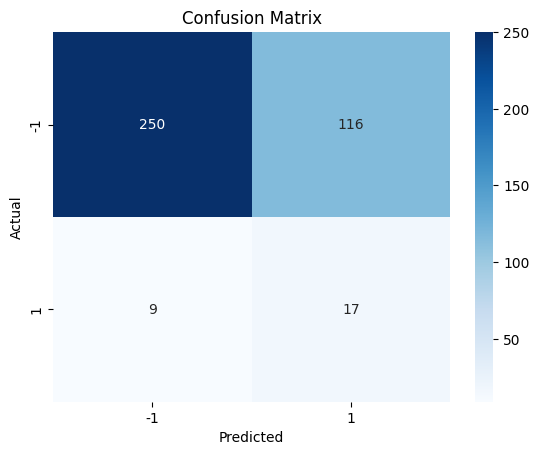

In [59]:
# Train the Chosen final model
final_model2 = KNeighborsClassifier(n_neighbors=105)
final_model2.fit(X_train_balanced1, y_train_balanced1)

# Test the model on the test set
y_pred = final_model2.predict(X_test_scaled1)

test_accuracy = accuracy_score(y_test, y_pred)

print(f"\nTest set accuracy: {test_accuracy:.4f}")
print("Classification report:")
print(classification_report(y_test, y_pred))

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['-1', '1'], yticklabels=['-1', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Test set accuracy: 0.4872
Classification report:
              precision    recall  f1-score   support

          -1       0.97      0.46      0.63       366
           1       0.10      0.81      0.17        26

    accuracy                           0.49       392
   macro avg       0.53      0.64      0.40       392
weighted avg       0.91      0.49      0.60       392

Confusion Matrix:
[[170 196]
 [  5  21]]


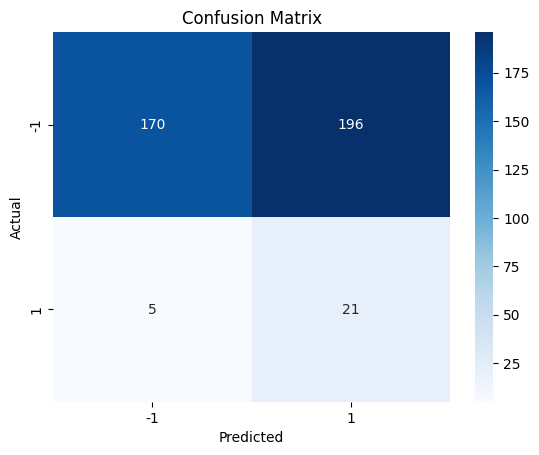

In [60]:
# Train the Chosen final model
final_model2 = KNeighborsClassifier(n_neighbors=1)
final_model2.fit(X_train_smote, y_train_smote)

# Test the model on the test set
y_pred = final_model2.predict(X_test_scaled1)

test_accuracy = accuracy_score(y_test, y_pred)

print(f"\nTest set accuracy: {test_accuracy:.4f}")
print("Classification report:")
print(classification_report(y_test, y_pred))

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['-1', '1'], yticklabels=['-1', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Set up parameter grid
param_grid = {
    'n_neighbors': range(1, 201),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

# Instantiate the KNeighborsClassifier
knn = KNeighborsClassifier()

# Instantiate GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')


# Fit the grid search to your data
grid_search.fit(X_train_balanced1, y_train_balanced1)

# Output the best parameters
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Test set accuracy: 0.9337
Classification report:
              precision    recall  f1-score   support

          -1       0.93      1.00      0.97       366
           1       0.00      0.00      0.00        26

    accuracy                           0.93       392
   macro avg       0.47      0.50      0.48       392
weighted avg       0.87      0.93      0.90       392

Confusion Matrix:
[[366   0]
 [ 26   0]]


c:\Users\Majeed Win10\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Majeed Win10\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Majeed Win10\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

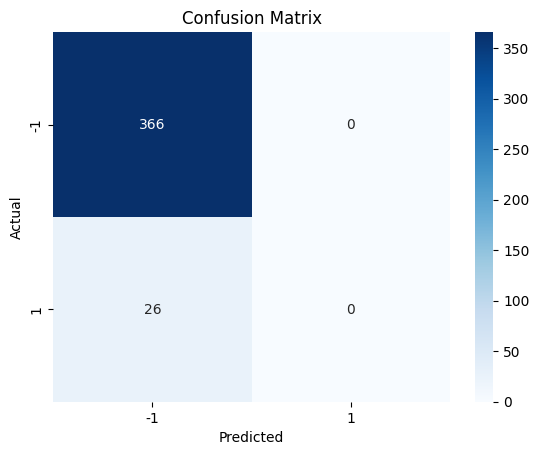

In [62]:
# Decision trees
best_parameters1=  {'criterion': 'entropy', 'max_depth': 10, 'max_features':
                     'log2', 'min_samples_leaf': 1, 'min_samples_split': 27, 'splitter': 'random'}

# Instantiate the DecisionTreeClassifier
final_model3 = DecisionTreeClassifier(**best_parameters1, random_state=42)

# Fit the model
final_model3.fit(X_train_imputed_knn, y_train)

# Test the model on the test set
y_pred = final_model3.predict(X_test_imputed1)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"\nTest set accuracy: {test_accuracy:.4f}")
print("Classification report:")
print(classification_report(y_test, y_pred))

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['-1', '1'], yticklabels=['-1', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()